# Bayesian MR pipeline


### Gene filtering step:

In order make sure we don’t uncover false positives and reduce the number of gene pairs that have cryptic relations, we remove all pseudogenes (as annotated by gencode), genes with mappability (cite) below 0.8, and genes that belong to the Major histocompatibility complex (MHC). The purpose of this filter is to reduce the number of statistically significant gene pairs that result from incorrectly mapped reads.

In [ ]:
# Read in gencode v.26 annotation

import pickle
import os

os.chdir('/tigress/BEE/RNAseq/Data/Resources/annotations/silver/')
genes = pickle.load(open('gencode.v26.genes', 'rb'))

# This dictionary is organized so that the chromosome IDs are the first index:
# Let's get an example tally of the number of each gene type for Chr 1:

type_dict = {}
for gene in genes['1']:
    gene_type = genes['1'][gene]['gene_type']
    if gene_type not in type_dict:
        type_dict[gene_type] = 0
    type_dict[gene_type] = type_dict[gene_type] + 1
    
print(type_dict)

<code>{'transcribed_unprocessed_pseudogene': 50, 'unprocessed_pseudogene': 208, 'miRNA': 158, 'lincRNA': 575, 'protein_coding': 2037, 'processed_pseudogene': 896, 'antisense': 504, 'processed_transcript': 34, 'snRNA': 219, 'transcribed_processed_pseudogene': 33, 'sense_intronic': 66, 'misc_RNA': 192, 'TEC': 33, 'transcribed_unitary_pseudogene': 17, 'snoRNA': 68, 'scaRNA': 14, 'rRNA': 69, 'unitary_pseudogene': 13, '3prime_overlapping_ncRNA': 5, 'polymorphic_pseudogene': 7, 'bidirectional_promoter_lncRNA': 2, 'sense_overlapping': 18, 'pseudogene': 5, 'IG_V_pseudogene': 1}</code>

As a first pass, we will take the protein_coding and lincRNA genes, while filtering out pseudogenes and antisense genes.

Also, we will filter out genes in Chr 6 Major histocompatibility complex (MHC) region, which is located in:

<code>chr6:28,510,120-33,480,577
6p22.1-21.3</code> 

for hg38, according to https://www.ncbi.nlm.nih.gov/grc/human/regions/MHC?asm=GRCh38

In [ ]:
chr_ids = set([x for x in genes])
out_f = open('/tigress/BEE/RNAseq/Data/Resources/annotations/silver/gene_filter/Bayes_MR_list.txt', 'w')
MHC = [28510120, 33480577]

for chr_id in chr_ids:
    if chr_id == '6':
        gene_list = [x for x in genes[chr_id] if (genes[chr_id][x]['gene_type'] in ['protein_coding', 'lincRNA']) and (int(genes[chr_id][x]['start']) < MHC[0] or int(genes[chr_id][x]['start']) > MHC[1])]
    else:
        gene_list = [x for x in genes[chr_id] if genes[chr_id][x]['gene_type'] in ['protein_coding', 'lincRNA']]
    out_f.write('\n'.join(gene_list) + '\n')
    
out_f.close()

This results in a gene list of length 27140, saved in file <code>/tigress/BEE/RNAseq/Data/Resources/annotations/silver/gene_filter/Bayes_MR_list.txt</code>

We will also enforce a gene mappability score at or above 0.8 in the pipeline script.

### SNP filtering step:

In order to keep consistent with the assumption that our tests are independent, we pre-select an LD-pruned set of SNPs, using the plink parameters --indep 50 5 2.

The resulting SNP set, at MAF of 5% and 1%, are saved in the directory:

<code>/tigress/BEE/RNAseq/Data/Genotype/gtex/v8/ld_prune/</code>

We will also enforce a SNP variance explained by covariates at or below 90% in the pipeline script.

### Subject filtering/separation step:

In order to make sure that we reduce the chance of inducing false relations by correcting for covariates that are not independent of the instrumental variable (most notably population structure), we segregate the test cohort into ‘EA’ (European-American) and ‘AA’ (African-American) groups, and the membership of this group is determined by fitting a Gaussian mixture model clustering (R package mclust) on the first 5 genotype PCs, which yields a MLE of 7 clusters.

In [ ]:
# R script:

setwd('/tigress/BEE/RNAseq/Data/Genotype/gtex/v8/support_files')
eigs = read.table('GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze_20PCs_eigenValues.txt', header=T)
pcs = read.table('GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze_20genotPCs.txt', header=T)
subj_table = read.table('/tigress/BEE/RNAseq/Data/Resources/gtex/tables/v8/subject_table.txt', header=T)

# First 5 pcs

pc_data = pcs[,c('PC1', 'PC2', 'PC3', 'PC4', 'PC5')]
rownames(pc_data) = pcs$FID
eigs = as.numeric(eigs)

rownames(pc_data) = sapply(rownames(pc_data), function(x) {paste0('GTEX-', strsplit(x, '-')[[1]][2])})
rownames(subj_table) = subj_table$SUBJID
pc_data$RACE = subj_table[rownames(pc_data),'RACE']

pc_data$PC1 = pc_data$PC1 * eigs[1]
pc_data$PC2 = pc_data$PC2 * eigs[2]
pc_data$PC3 = pc_data$PC3 * eigs[3]
pc_data$PC4 = pc_data$PC4 * eigs[4]
pc_data$PC5 = pc_data$PC5 * eigs[5]

save(pc_data, file = '5genotPCs.RData')

pc_data[which(pc_data$RACE == 99),'RACE'] = 0
qplot(pc_data$PC1, pc_data$PC2, col=pc_data$RACE)

library(mclust)

clust = Mclust(pc_data[,c(1:5)])

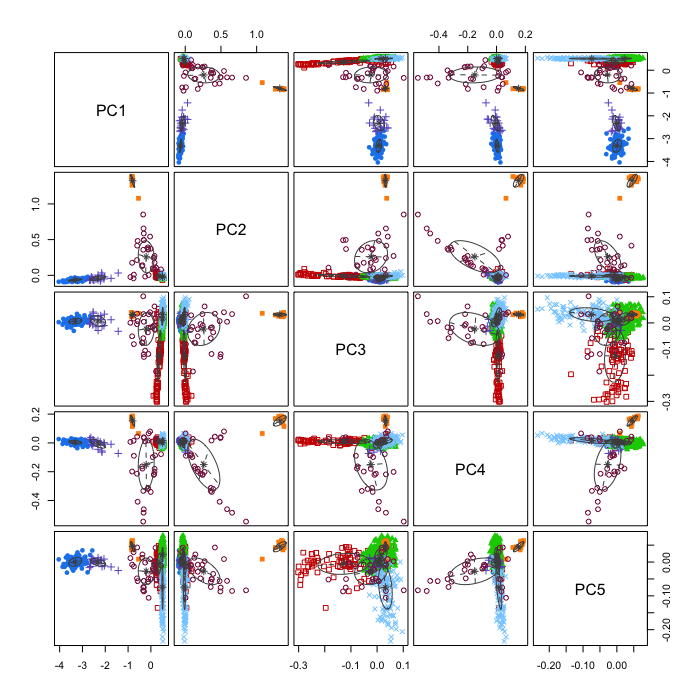

In [5]:
from IPython.display import Image
Image(filename='/Users/brian_jo/Desktop/Project/RNAseq_pipeline/Analysis/auxiliary/genotype/v8/5PC_clust.png', width = 700)

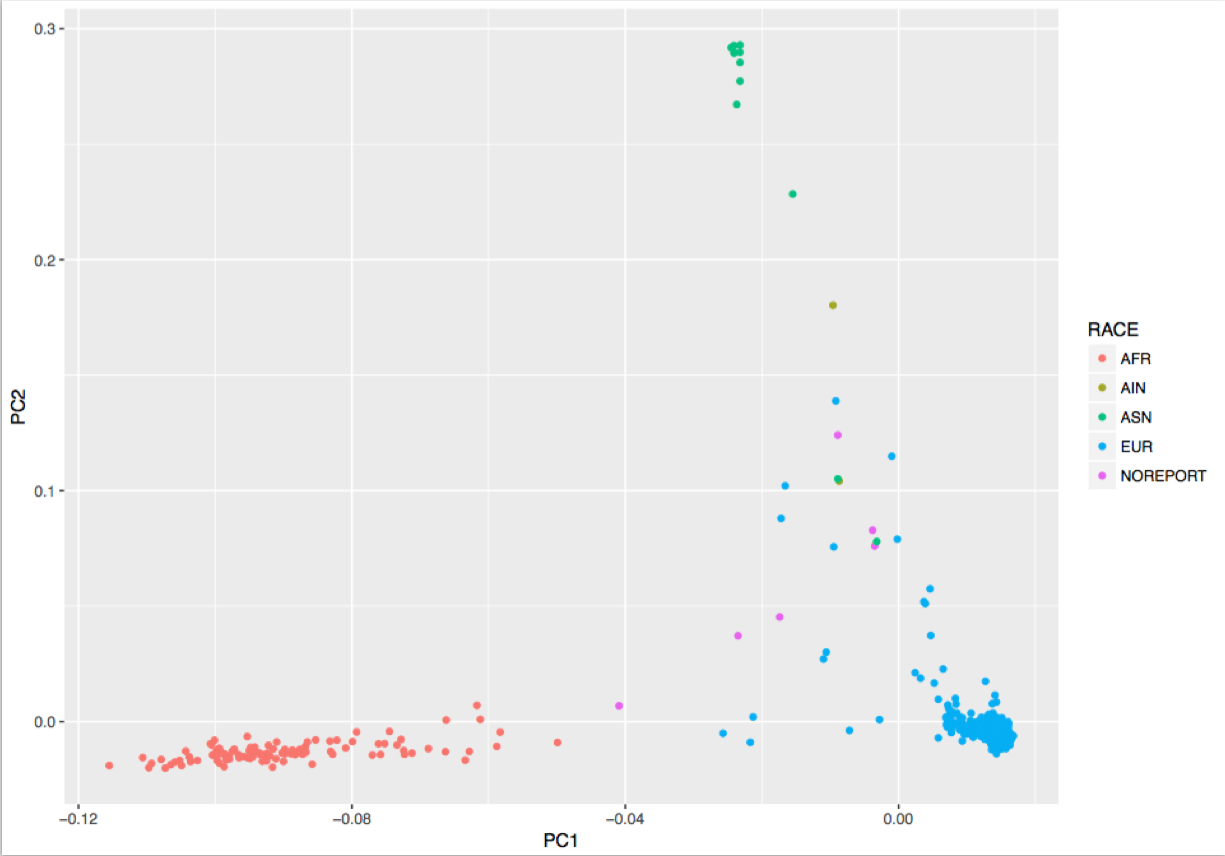

In [6]:
Image(filename='/Users/brian_jo/Desktop/Project/RNAseq_pipeline/Analysis/auxiliary/genotype/v8/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_genoPCs_by_race_plots1.png', width = 600) 

The mclust result that has an MLE of 7 clusters, show two clusters that are distinctly African American in self-reported race (85 and 19 individuals, 104 total), and three clusters that are distinctly White American (86, 498 and 109 individuals, 693 total). Of the other two clusters, one contains mainly individuals of Asian descent (10 individuals), and the other of many unreported and potentially mixed individuals (31 individuals), but these two clusters were not included in our analysis. Now, I save the list of subjects that belong to each cluster in separate files for the pipeline:

In [ ]:
# R script:
setwd('t')
load('5genotPCs.RData')
library(mclust)
clust = Mclust(pc_data[,c(1:5)])

# Note: running mclust on different environments have shown to result in different clustering results.
# Maybe a better clustering algorithm is desirable.

write.table(names(clust$classification[clust$classification == 1]), file = 'pop_clust/AA_1.txt', col.names = F, row.names = F, quote = F)
write.table(names(clust$classification[clust$classification == 4]), file = 'pop_clust/AA_2.txt', col.names = F, row.names = F, quote = F)
write.table(names(clust$classification[clust$classification == 3]), file = 'pop_clust/EA_1.txt', col.names = F, row.names = F, quote = F)
write.table(names(clust$classification[clust$classification == 6]), file = 'pop_clust/EA_2.txt', col.names = F, row.names = F, quote = F)
write.table(names(clust$classification[clust$classification == 2]), file = 'pop_clust/EA_3.txt', col.names = F, row.names = F, quote = F)
write.table(names(clust$classification[clust$classification == 5]), file = 'pop_clust/other_1.txt', col.names = F, row.names = F, quote = F)
write.table(names(clust$classification[clust$classification == 7]), file = 'pop_clust/other_2.txt', col.names = F, row.names = F, quote = F)

### Frequentist and Bayesian MR pipeline:

Now we're ready to run our pipeline script, which proceeds as follows:

- First, calculate the Wakefield Approximate Bayes Factors (WABF) and the subsequent Posterior probability of Association (PPA) to obtain the list of cis-eQTLs and trans-eQTLs, with the distance threshold of 1MB from the gene. The parameters are: cis-risk of 1.5, and the prior W parameter being (log(cis-risk) / 1.96)^2, to convey our belief that there is 95% chance that a cis-eQTL will display a relative risk above or equal to 1.5. 
- If there are SNPs that have both cis-eQTLs and trans-eQTLs with PPA greater than equal to 0.5, calculate both the frequentist (Wald) and Bayesian (approximate) MR statistics for the SNP, cis-gene and trans-gene trio, with the MR statistic conveying our confidence in the fact that variation in cis-gene expression is causal for variation in trans-gene expression, as evidenced by IV analysis. 
- TODO: Also run the same set of trios through a colocalization analysis (R package coloc), in order to provide a comparison with an existing Bayesian approach for causal inference.

Refer to the following scripts:

<code>
https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/causality/bayes_MR/main_pipeline/wabf_calculate_bayes_factor_wrapper.py

https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/causality/bayes_MR/main_pipeline/wabf_calculate_bayes_factor.R

https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/causality/bayes_MR/main_pipeline/wabf_calculate_MR_stats_wrapper.py

https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/causality/bayes_MR/main_pipeline/wabf_calculate_MR_stats.R

https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/causality/bayes_MR/main_pipeline/wabf_functions.R
</code>


In [ ]:
%%bash

# Bayes Factor calculation script for cis- and trans-eQTLs
python /tigress/BEE/RNAseq//Scripts/causality/bayes_MR/main_pipeline/wabf_calculate_bayes_factor_wrapper.py

# MR script for Frequentist and Bayesian versions
python /tigress/BEE/RNAseq//Scripts/causality/bayes_MR/main_pipeline/wabf_calculate_MR_stats_wrapper.py

The resulting cis- and trans-eQTLs are saved in the following directory:

<code>/tigress/BEE/RNAseq/Output/causality/gtex/bayes_MR/eqtls/</code>

The resulting Frequentist and Bayesian MR stats for SNP-gene-gene trios are are saved in the following directory:

<code>/tigress/BEE/RNAseq/Output/causality/gtex/bayes_MR/MR_stats/</code>
